# Segmentační metoda

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers, mixed_precision
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal
def sliding_window_inference(nifti_path, model: Model, window_shape=(256, 256, 64), stride=(128, 128, 32)):
    """
    Apply a trained 3D model using sliding window inference on a NIfTI volume.

    Parameters:
        nifti_path (str): path to the CT scan (file name).
        model (Model): Trained Keras model.
        window_shape (tuple): Shape of the sliding window.
        stride (tuple): Step size of sliding window.

    Returns:
        output_volume (np.ndarray): Prediction mask for the entire volume.
    """
    nifti_path = Path(nifti_path)

    # === 1. Load NIfTI file ===
    raw_nii = nib.load(nifti_path)
    raw = raw_nii.get_fdata()
    spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)

    # === 2. Apply windowing (CT intensity range) ===
    raw = methods.window(raw, center=40, width=400)
    bones = methods.window(raw, center=270, width=310)

    # === 3. Resample to isotropic voxels ===
    raw = methods.resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)
    bones = methods.resample_to_voxelsize(bones, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)

    # === 4. Normalize and expand to 3 channels ===
    raw = (raw - np.min(raw)) / (np.max(raw) - np.min(raw) + 1e-5)
    raw = np.stack([raw] * 3, axis=-1)  # (Z, Y, X, 3)

    original_shape = raw.shape[:-1]

    # === 5. Padding ===
    pad_width = [
        (0, max(0, window_shape[0] - original_shape[0] % stride[0])),
        (0, max(0, window_shape[1] - original_shape[1] % stride[1])),
        (0, max(0, window_shape[2] - original_shape[2] % stride[2])),
        (0, 0)
    ]
    volume_padded = np.pad(raw, pad_width, mode='constant')
    padded_shape = volume_padded.shape

    output = np.zeros(padded_shape[:-1], dtype=np.float32)
    count_map = np.zeros(padded_shape[:-1], dtype=np.float32)

    # === 6. Sliding window inference ===
    for z in range(0, padded_shape[0] - window_shape[0] + 1, stride[0]):
        for y in range(0, padded_shape[1] - window_shape[1] + 1, stride[1]):
            for x in range(0, padded_shape[2] - window_shape[2] + 1, stride[2]):
                patch = volume_padded[z:z+window_shape[0],
                                      y:y+window_shape[1],
                                      x:x+window_shape[2], :]

                patch_input = np.expand_dims(patch, axis=0)  # Batch dim
                prediction = model.predict(patch_input, verbose=0)[0]

                output[z:z+window_shape[0],
                       y:y+window_shape[1],
                       x:x+window_shape[2]] += prediction[..., 0]
                count_map[z:z+window_shape[0],
                          y:y+window_shape[1],
                          x:x+window_shape[2]] += 1

    output /= np.maximum(count_map, 1e-5)

    # Oříznutí na původní tvar vstupu
    output = output[:original_shape[0], :original_shape[1], :original_shape[2]]

    # Prahování výstupu modelu (binární segmentace)
    output = (output > 0.2).astype(np.uint8)

    # Získání binární masky kostí
    bones = (bones / np.max(bones) > 0.5).astype(np.uint8)

    # Inicializace výsledné matice nulami
    result = np.zeros_like(output, dtype=np.uint8)

    # Zapsání hodnot do výsledné matice podle priorit:
    # nejprve output (1), pak bones (2) přepíšou 1 na 2 tam, kde se překrývají
    result[output == 1] = 1
    result[bones == 1] = 2

    return result

2025-05-14 07:12:00.455055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 07:12:00.480170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 07:12:00.487486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 07:12:00.505242: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os
import numpy as np
from pathlib import Path
import nibabel as nib
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # silence warning logs
singularity_name = os.environ.get("SINGULARITY_NAME")
if singularity_name: print("Singularity:\t", singularity_name)    
print("version_info:\t", sys.version_info)
print("executable:\t",sys.executable)
print("pwd:\t\t", os.getcwd())
import methods

def segment_pilsen_pigs(input_volume_path, model_path):
    # NLoad saved model
    with strategy.scope():
        # Define custom objects
        custom_objects = {
            "dice_coef": methods.dice_coef,
            "precision": methods.precision,
            "recall": methods.recall,
            "f1_score": methods.f1_score,
            "weighted_binary_crossentropy": methods.weighted_binary_crossentropy
        }
        # Load the model with custom objects
        #model = tf.keras.models.load_model(project_text+"/"+text_to_save+"_processor.h5", custom_objects=custom_objects)
        loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    
    output = sliding_window_inference(
        nifti_path=input_volume_path,
        model=loaded_model,
        window_shape=(256, 256, 128),
        stride=(128, 128, 64)
    )
        
    output_dir = Path('predikce')
    #os.makedirs(os.path.dirname(output_dir), exist_ok=True) # Make directory if does not exists
        
    # If you have an affine from the original scan, use it. Otherwise use identity
    affine = np.eye(4)
    
    # Create and save NIfTI files
    nib.save(nib.Nifti1Image(output, affine), output_dir/'output.nii.gz')
    
    print("NIfTI files saved successfully.")
    return output

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num GPUs Available:  2
Singularity:	 TensorFlow:25.02-tf2-py3.SIF
version_info:	 sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
executable:	 /usr/bin/python
pwd:		 /auto/brno2/home/romova9


In [ ]:
# NLoad saved model and segment
input_volume_path = "2D_to_3D/data/pilsen_pigs/Tx023D_Ven/Tx023D_Ven.nii.gz"
model_path = "3D_UNET_final/pisen_pigs_big:weight__cycle_37.h5"
output = segment_pilsen_pigs(input_volume_path, model_path)

In [ ]:
output.shape

In [22]:
print(np.min(output), np.max(output))
# output = (output > 0.2).astype(np.float32)

0 2


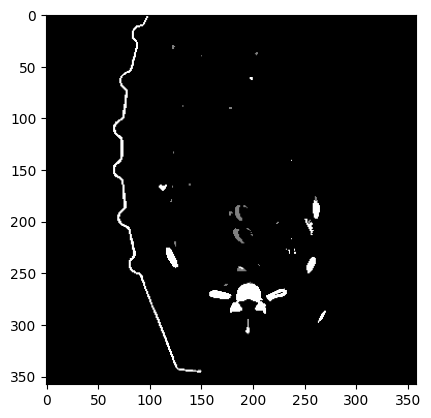

In [44]:
import matplotlib.pyplot as plt
plt.imshow(output[:,:,400],cmap="gray")

# Uložení modelu do starší verze Tensorflow

In [24]:
import methods
file = "pisen_pigs_big:weight__cycle_37.h5"

original_model_path = "3D_UNET_final/" + file
end_path = "3D_UNET_final_transformed/" + file

custom_objects = {
            "dice_coef": methods.dice_coef,
            "precision": methods.precision,
            "recall": methods.recall,
            "f1_score": methods.f1_score,
            "weighted_binary_crossentropy": methods.weighted_binary_crossentropy
        }

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeNormal

# ✅ Load original model
original_model = tf.keras.models.load_model(
    original_model_path,
    custom_objects=custom_objects
)
print(original_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 256, 256, 128, 8)     656       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 256, 256, 128, 8)     1736      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 256, 256, 128, 8)     1736      ['conv3d_1[0][0]']            
                                                                                              

In [26]:
# ✳️ Helper function to create conv blocks
def conv_block(x, filters, n_convs, init, dropout_rate=0.2):
    for _ in range(n_convs):
        x = layers.Conv3D(filters, (3, 3, 3), padding='same', kernel_initializer=init)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ✳️ U-Net architecture
def get_3d_unet(shape=(256, 256, 128), n_convs_per_block=4):
    tf.keras.backend.set_image_data_format('channels_last')
    seed = 42
    tf.random.set_seed(seed)
    init = HeNormal(seed=seed)
    inputs = layers.Input(shape=(*shape, 3))

    # Encoder
    filters = [8, 16, 32, 64, 128]
    encoders = []
    x = inputs
    for f in filters:
        x = conv_block(x, f, n_convs_per_block, init, dropout_rate=0.2)
        encoders.append(x)
        x = layers.MaxPooling3D((2, 2, 2))(x)

    # Bottleneck
    x = conv_block(x, 256, n_convs_per_block, init, dropout_rate=0.3)

    # Decoder
    for i, f in reversed(list(enumerate(filters))):
        x = layers.Conv3DTranspose(f, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = layers.concatenate([x, encoders[i]])
        x = conv_block(x, f, n_convs_per_block, init, dropout_rate=0.2)

    outputs = layers.Conv3D(2, (1, 1, 1), activation='sigmoid')(x)
    return Model(inputs, outputs)

# ✅ Rebuild a new model with the same architecture structure
model_clean = get_3d_unet()
print(model_clean.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 128, 3)]   0         []                            
                                                                                                  
 conv3d_180 (Conv3D)         (None, 256, 256, 128, 8)     656       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_176 (B  (None, 256, 256, 128, 8)     32        ['conv3d_180[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_176 (Activation  (None, 256, 256, 128, 8)     0         ['batch_normalization_17

In [27]:
# Ensure that the layers are compatible and try to load weights layer by layer
for layer_clean, layer_orig in zip(model_clean.layers, original_model.layers):
    # Check if both layers have weights to be copied
    if layer_clean.get_weights() and layer_orig.get_weights():
        try:
            # Manually assign weights where they are compatible
            if layer_clean.get_weights()[0].shape == layer_orig.get_weights()[0].shape:
                layer_clean.set_weights(layer_orig.get_weights())
                print(f"Weights transferred for layer: {layer_clean.name}")
            else:
                print(f"Weight mismatch for layer: {layer_clean.name} - skipping")
        except Exception as e:
            print(f"Error copying weights for layer {layer_clean.name}: {e}")

# ✅ Compile the cleaned model
model_clean.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', methods.dice_coef]
)

# ✅ Save the restructured model
model_clean.save(end_path)
print()
print(end_path)

Weights transferred for layer: conv3d_180
Weight mismatch for layer: batch_normalization_176 - skipping
Weights transferred for layer: conv3d_181
Weight mismatch for layer: conv3d_182 - skipping
Weight mismatch for layer: batch_normalization_178 - skipping
Weight mismatch for layer: conv3d_184 - skipping
Weight mismatch for layer: batch_normalization_180 - skipping
Weight mismatch for layer: conv3d_185 - skipping
Weight mismatch for layer: batch_normalization_181 - skipping
Weight mismatch for layer: conv3d_186 - skipping
Weight mismatch for layer: conv3d_187 - skipping
Weight mismatch for layer: batch_normalization_183 - skipping
Weight mismatch for layer: batch_normalization_184 - skipping
Weight mismatch for layer: conv3d_189 - skipping
Weight mismatch for layer: batch_normalization_185 - skipping
Weight mismatch for layer: batch_normalization_186 - skipping
Weight mismatch for layer: conv3d_191 - skipping
Weight mismatch for layer: batch_normalization_187 - skipping
Weight mismatch

# Vypis prostredi

In [ ]:
import pip
import subprocess

# Uložení seznamu nainstalovaných balíčků
with open("original_environment.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

print("Seznam balíčků uložen do original_environment.txt")


In [35]:
import keras
print("Keras version:", keras.__version__)

Keras version: 3.3.2
